## 1.2.2. find HVGs

This notebook can be used to find the highly variable genes in the control subset. This is one of the four notebooks that will help us validate the cell type labels in the control subset.

PS: perhaps it is a bit confusing that the cell types are already assigned to the clusters in notebook 1.1, and we look at the HVGs only afterwards. In reality, we looked at the HVGs (and the other indicators found in notebook 1.2.1 - 1.2.5) before assigning cell types to the clusters. However, we felt that the pipeline would make more sense in this order, because you can run notebook 1.1 and get the complete single cell object (.h5ad file), without the need for running this notebook first.

In [1]:
### loading python libraries

# standard libraries
import numpy as np
import pandas as pd

# single cell libraries
import anndata as ad
import scanpy as sc
sc.settings.verbosity = 0 

# plotting libraries
from matplotlib import pyplot as plt

# other 
import warnings
warnings.filterwarnings('ignore') #ignore filter warnings
import sklearn as sk #used for L2 normalization
import sklearn.preprocessing #used for L2 normalization
import scipy #for transforming matrix from sparse to dense
from scipy.cluster.hierarchy import linkage, leaves_list #for hiearchical clustering
from scipy.spatial.distance import pdist #for hiearchical clustering

# import own functions
from utils import *

### Load data

Here, we load the processed control subset (as filtered in notebook 1.1).

In [2]:
### load Anndata object with the control subset 
adata_path = "../data/count_matrices/control_filtered.h5ad"
adata = sc.read_h5ad(adata_path)

### Get HVGs
Here, calculate the top 500 most variable genes in the whole control subset. We are using the Pearson residuals method, which has been proposed by Lause, Berens & Kobak in https://doi.org/10.1186/s13059-021-02451-7 (2021). Their code is also available on Github: https://github.com/berenslab/umi-normalization).

In [3]:
hvgs = get_hvgs(adata, no_of_hvgs=500, theta=100)

### Plot HVGs

Here, we will create a dotplot (see https://scanpy.readthedocs.io/en/stable/generated/scanpy.pl.dotplot.html for documentation) with the top 30 HVGs. Instead of plotting the genes based on their rank, we will plot them after clustering them based on similarity (hierarchical clustering).

In [4]:
### select HVGs (0-50)
top_hvgs = hvgs[0:50]

In [5]:
### L2 normalize dataset
adata.X = sk.preprocessing.normalize(adata.X, norm='l2')

In [6]:
### get the average expression of HVGs in each cluster
clusters = adata.obs["clusters"].cat.categories
expression_hvgs = adata[:,top_hvgs].X.toarray()
expression_hvgs = pd.DataFrame(expression_hvgs,columns=top_hvgs,index=adata.obs["clusters"])
mean_expr_hvgs = expression_hvgs.groupby(level=0).mean()

### calculate hierarchical clustering
Y = pdist(mean_expr_hvgs.T.values)
Z = linkage(Y, "ward")

Text(0.45, 0.85, 'highly variable genes (top 1-50)')

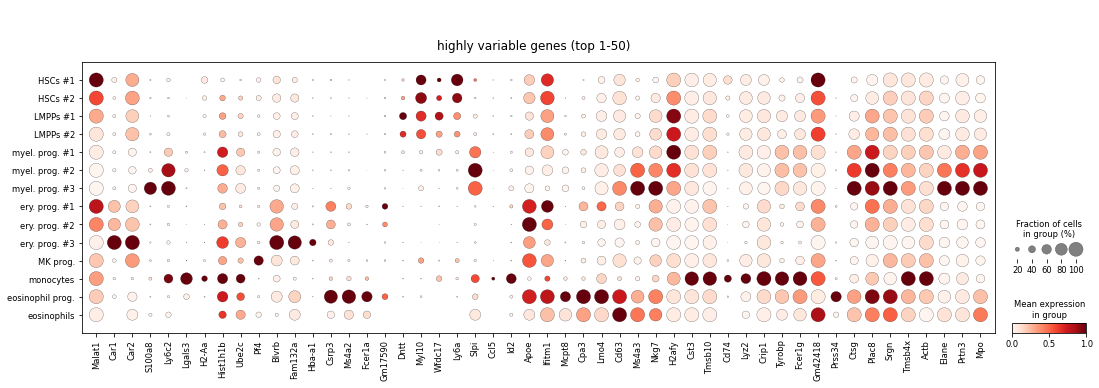

In [7]:
### plot top HVGs in dotplot
fig, axs = plt.subplots(1, 1, figsize=(18, 6))

sc.pl.dotplot(adata, hvgs[leaves_list(Z)],
              groupby="clusters", standard_scale='var',
              title="",
              ax=axs, show=False)

axs.set_title('highly variable genes (top 1-50)', y=0.85, x=0.45)

# save figure
#save_path = "../figures/1.2.2.HVGs_1-50.png"
#fig.savefig(save_path, bbox_inches='tight', format='png', dpi=300)

### Save HVGs
Here, you can save the HVGs for later purposes. The list of HVGs can also be found in the Github repository under `/results/cluster_annotation/HVGs_top500_control.csv`.

In [8]:
### save HVGs in csv file
hvgs_df = pd.DataFrame(hvgs, columns=["hvgs"])
name_file = "HVGs_top500_control.csv"
save_path  = "../results/cluster_annotation/" + name_file
hvgs_df.to_csv(save_path, header=True, index=False)

For some downstream purposes we need also the list of HVGs for the complete dataset. Here, we calculate the top 2000 HVGs for each timepoint and merge those together. This is copied from notebook 1.3.

In [9]:
### load Anndata object with the HSPC dataset (all four subsets incl.)
adata_path = "../data/count_matrices/all_filtered.h5ad"
adata = sc.read_h5ad(adata_path)

In [10]:
### get HVGs for each timepoint separately
hvgs = [get_hvgs(adata[adata.obs["time"]==timepoint], no_of_hvgs=2000, theta=100)for timepoint in adata.obs["time"].cat.categories]
hvgs = np.unique(np.concatenate(hvgs, axis=0)) #remove double entries

In [11]:
### save HVGs in csv file
hvgs_df = pd.DataFrame(hvgs, columns=["hvgs"])
name_file = "HVGs_top2000_all_timepoints_merged.csv"
save_path  = "../results/cluster_annotation/" + name_file
hvgs_df.to_csv(save_path, header=True, index=False)